In [ ]:
# I don't find any high-accuracy Plus-Minute prediction from the box score stats I use.
# The best predictions come from Ridge Regression, but still not particularly performant.
# I show some correlation graphs to sort of estimate the most "impactful" features on plus-minus
# While not technically a default box score stat, True Shooting % is the most impactful causative metric I find

In [1]:
import requests
import json
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import re
from sklearn.preprocessing import MultiLabelBinarizer
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, LinearRegression
import tensorflow as tf
pd.set_option('display.max_columns',500)

In [2]:
# Compiling links for NBA stats tables
link_dict = {
    'team_game': 'https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=',
    'player_game': 'https://stats.nba.com/stats/leaguedashplayerstats?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&GameSegment=&Height=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&SeasonSegment=&SeasonType=Regular+Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=&Weight=',
    'player_hustle': 'https://stats.nba.com/stats/leaguehustlestatsplayer?College=&Conference=&Country=&DateFrom=&DateTo=&Division=&DraftPick=&DraftYear=&GameScope=&Height=&LastNGames=0&LeagueID=00&Location=&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&SeasonSegment=&SeasonType=Regular+Season&TeamID=0&VsConference=&VsDivision=&Weight=',
    'player_general': 'https://stats.nba.com/stats/playerindex?LeagueID=00'
}

In [3]:
# Headers for querying NBA JSON data api
headers  = {
    'Connection': 'keep-alive',
    'Accept': 'application/json, text/plain, */*',
    'x-nba-stats-token': 'true',
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/79.0.3945.130 Safari/537.36',
    'x-nba-stats-origin': 'stats',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-Mode': 'cors',
    'Referer': 'https://stats.nba.com/',
    'Accept-Encoding': 'gzip, deflate, br',
    'Accept-Language': 'en-US,en;q=0.9',
}

In [4]:
seasons = ['2017-18','2018-19','2019-20','2020-21','2021-22']
# # Choose a season type for parameter passing
# season_type = 'Playoffs'
season_type = 'Regular+Season'

In [5]:
def get_player_general(season=max(seasons),season_type=season_type):
    params = {'season':'2021-22','SeasonType':season_type,'Historical':'1'}
    r = requests.get(url = link_dict['player_general'],headers=headers,params=params).json()
    player_general = pd.DataFrame(r['resultSets'][0]['rowSet'],columns=r['resultSets'][0]['headers'])
    player_general = player_general[[#'PLAYER_FIRST_NAME','PLAYER_LAST_NAME','TEAM_ABBREVIATION',
                                     'PERSON_ID',
                                     'POSITION','HEIGHT','WEIGHT','DRAFT_YEAR','FROM_YEAR','TO_YEAR']]
#     player_general['SEASON'] = season
    player_general.rename({'PERSON_ID':'PLAYER_ID'},axis=1,inplace=True)
    return player_general

In [6]:
def get_player_game(season,min_games=40,min_minutes=15,season_type=season_type):
    drop_cols = ['_RANK','_FANTASY','CFPARA','CFID','TD3','DD2','TEAM_ABBREVIATION','_NAME','NICKNAME']
    params = {'season':season, 'SeasonType':season_type}
    r = requests.get(url = link_dict['player_game'],headers=headers,params=params).json()
    player_game = pd.DataFrame(r['resultSets'][0]['rowSet'],columns=r['resultSets'][0]['headers'])
    player_game['FTMissed']=player_game['FTA']-player_game['FTM']
    player_game['FGMissed']=player_game['FGA']-player_game['FGM']
    player_game['FG2M']=player_game['FGM']-player_game['FG3M']
    player_game['SEASON'] = season
    player_game.drop([col for col in player_game.columns
        if re.search(r"(?=("+'|'.join(drop_cols)+r"))", col)],axis=1,inplace=True) # drop matching columns
    player_game = player_game[(player_game['GP']>=min_games)\
                &(player_game['MIN']>=min_minutes)] # only keep players with enough games and minutes per game
    return player_game

In [7]:
def get_player_hustle(season,season_type=season_type):
    params = {'season':season, 'SeasonType':season_type}
    r = requests.get(url = link_dict['player_hustle'],headers=headers,params=params).json()
    player_hustle = pd.DataFrame(r['resultSets'][0]['rowSet'],columns=r['resultSets'][0]['headers'])
    player_hustle['SEASON'] = season
    return player_hustle

In [8]:
def make_or_concat(seasons, function):
    for idx, season in enumerate(seasons):
        if idx == 0:
            df = function(season)
        else:
            df = pd.concat([df,function(season)], ignore_index=True, sort=False)
    return df

In [9]:
# Merge and clean the dataframe
player_general = get_player_general()
player_game = make_or_concat(seasons, get_player_game)
player_hustle = make_or_concat(seasons, get_player_hustle)
all_stats = player_hustle\
    .merge(player_general, how='inner', on=['PLAYER_ID'])\
    .merge(player_game.drop('MIN',axis=1),how='inner',on=['PLAYER_ID','SEASON'])\
    .drop('G',axis=1)
drop_cols = ['_x','NICK','TEAM_ID','_y']
drop_col_matches = [col for col in all_stats.columns
    if re.search(r"(?=("+'|'.join(drop_cols)+r"))", col)]
all_stats = all_stats.drop(drop_col_matches,axis=1) # drop matching columns
all_stats

,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,MIN,CONTESTED_SHOTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,DEFLECTIONS,CHARGES_DRAWN,SCREEN_ASSISTS,SCREEN_AST_PTS,OFF_LOOSE_BALLS_RECOVERED,DEF_LOOSE_BALLS_RECOVERED,LOOSE_BALLS_RECOVERED,PCT_LOOSE_BALLS_RECOVERED_OFF,PCT_LOOSE_BALLS_RECOVERED_DEF,OFF_BOXOUTS,DEF_BOXOUTS,BOX_OUTS,BOX_OUT_PLAYER_TEAM_REBS,BOX_OUT_PLAYER_REBS,PCT_BOX_OUTS_OFF,PCT_BOX_OUTS_DEF,PCT_BOX_OUTS_TEAM_REB,PCT_BOX_OUTS_REB,SEASON,POSITION,HEIGHT,WEIGHT,DRAFT_YEAR,FROM_YEAR,TO_YEAR,GP,W,L,W_PCT,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,FTMissed,FGMissed,FG2M
0,203932,Aaron Gordon,ORL,32.9,6.47,4.69,1.78,1.41,0.07,0.90,1.95,0.52,0.69,1.21,0.429,0.571,0.19,2.53,2.72,1.29,0.36,0.070,0.930,0.852,0.239,2017-18,F,6-8,235,2014.0,2014,2021,58,19,39,0.328,6.5,14.9,0.434,2.0,5.9,0.336,2.7,3.9,0.698,1.5,6.4,7.9,2.3,1.8,1.0,0.8,0.7,1.9,3.3,17.6,-1.6,1.2,8.4,4.5
1,203932,Aaron Gordon,ORL,33.8,6.53,4.42,2.10,1.29,0.01,0.87,2.08,0.62,0.60,1.22,0.505,0.495,0.22,2.18,2.40,1.14,0.38,0.091,0.909,0.856,0.288,2018-19,F,6-8,235,2014.0,2014,2021,78,40,38,0.513,6.0,13.4,0.449,1.6,4.4,0.349,2.4,3.2,0.731,1.7,5.7,7.4,3.7,2.1,0.7,0.7,0.7,2.2,3.4,16.0,1.4,0.8,7.4,4.4
2,203932,Aaron Gordon,ORL,32.5,5.32,3.37,1.95,1.02,0.02,0.89,1.92,0.53,0.55,1.08,0.493,0.507,0.23,0.85,1.08,0.63,0.34,0.209,0.791,0.929,0.500,2019-20,F,6-8,235,2014.0,2014,2021,62,30,32,0.484,5.4,12.4,0.437,1.2,3.8,0.308,2.4,3.6,0.674,1.7,5.9,7.7,3.7,1.6,0.8,0.6,0.7,2.0,3.3,14.4,-1.1,1.2,7.0,4.2
3,203932,Aaron Gordon,DEN,27.7,3.78,2.46,1.32,1.02,0.00,0.52,1.22,0.42,0.22,0.64,0.656,0.344,0.20,0.18,0.38,0.34,0.30,0.526,0.474,0.944,0.833,2020-21,F,6-8,235,2014.0,2014,2021,50,29,21,0.580,4.6,10.0,0.463,1.2,3.5,0.335,1.9,3.0,0.651,1.5,4.1,5.7,3.2,1.9,0.7,0.7,0.6,1.8,2.7,12.4,1.2,1.1,5.4,3.4
4,203932,Aaron Gordon,DEN,31.7,5.32,3.47,1.85,0.91,0.01,0.71,1.73,0.41,0.25,0.67,0.620,0.380,0.13,0.39,0.52,0.44,0.32,0.256,0.744,0.943,0.686,2021-22,F,6-8,235,2014.0,2014,2021,75,46,29,0.613,5.8,11.1,0.520,1.2,3.5,0.335,2.3,3.1,0.743,1.7,4.2,5.9,2.5,1.8,0.6,0.6,0.7,2.0,2.7,15.0,4.3,0.8,5.3,4.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,1629656,Quentin Grimes,NYK,17.1,3.30,1.52,1.78,1.37,0.00,0.04,0.09,0.24,0.26,0.50,0.478,0.522,0.00,0.02,0.02,0.02,0.00,0.000,1.000,1.000,0.000,2021-22,G,6-4,210,2021.0,2021,2021,46,21,25,0.457,2.1,5.1,0.404,1.6,4.1,0.381,0.3,0.4,0.684,0.5,1.5,2.0,1.0,0.6,0.7,0.2,0.0,1.6,0.5,6.0,-1.2,0.1,3.0,0.5
1457,1630567,Scottie Barnes,TOR,35.4,9.00,5.28,3.72,2.34,0.05,1.07,2.58,0.41,0.30,0.70,0.577,0.423,0.28,1.23,1.51,1.34,0.58,0.188,0.813,0.925,0.402,2021-22,F,6-7,225,2021.0,2021,2021,74,43,31,0.581,6.2,12.6,0.492,0.8,2.6,0.301,2.1,2.9,0.735,2.6,4.9,7.5,3.5,1.8,1.1,0.7,0.5,2.6,2.9,15.3,0.9,0.8,6.4,5.4
1458,1630544,Tre Mann,OKC,22.8,3.40,1.37,2.03,1.18,0.03,0.07,0.13,0.23,0.20,0.43,0.538,0.462,0.00,0.18,0.18,0.18,0.07,0.000,1.000,1.000,0.364,2021-22,G,6-3,178,2021.0,2021,2021,60,17,43,0.283,3.9,9.8,0.393,1.6,4.5,0.360,1.1,1.4,0.793,0.4,2.4,2.9,1.5,1.2,0.8,0.2,0.6,1.7,1.2,10.4,-4.6,0.3,5.9,2.3
1459,1630570,Trendon Watford,POR,18.1,4.60,2.60,2.00,1.10,0.02,1.56,3.77,0.38,0.04,0.42,0.900,0.100,0.15,0.69,0.83,0.67,0.33,0.175,0.825,0.970,0.485,2021-22,F,6-8,237,NaN,2021,2021,48,16,32,0.333,3.0,5.6,0.532,0.2,0.8,0.237,1.5,2.0,0.755,1.2,3.0,4.1,1.7,0.9,0.5,0.6,0.4,2.4,1.6,7.6,-7.3,0.5,2.6,2.8


In [10]:
# Clean and add columns to the stats dataframe
all_stats.rename({'PF':'FOULS'},axis=1,inplace=True)
# Get dummies for each position
all_stats['POSITION2'] = all_stats['POSITION'].str.split('-')
all_stats = pd.get_dummies(all_stats, columns = ['POSITION'])
all_stats['HEIGHT'] = all_stats['HEIGHT'].str.split('-').str[0].astype(int)*12\
    +all_stats['HEIGHT'].str.split('-').str[1].astype(int)
# Also do a MLB of each combined position (C-F, F-G, etc.)
mlb = MultiLabelBinarizer()
all_stats = all_stats.merge(pd.DataFrame(mlb.fit_transform(all_stats['POSITION2']),columns=mlb.classes_, index=all_stats.index),
                     how='inner', left_index=True, right_index=True).drop(['POSITION2'],axis=1)
all_stats['TRUE_SHOOTING_PCT'] = all_stats['PTS']/(0.44*all_stats['FTA']+all_stats['FGA'])
all_stats['FG2A'] = all_stats['FGA'] - all_stats['FG3A']
all_stats['FG2M'] = all_stats['FGM'] - all_stats['FG3M']
all_stats['FG2_PCT'] = all_stats['FG2M']/all_stats['FG2A']
all_stats

,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,MIN,CONTESTED_SHOTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,DEFLECTIONS,CHARGES_DRAWN,SCREEN_ASSISTS,SCREEN_AST_PTS,OFF_LOOSE_BALLS_RECOVERED,DEF_LOOSE_BALLS_RECOVERED,LOOSE_BALLS_RECOVERED,PCT_LOOSE_BALLS_RECOVERED_OFF,PCT_LOOSE_BALLS_RECOVERED_DEF,OFF_BOXOUTS,DEF_BOXOUTS,BOX_OUTS,BOX_OUT_PLAYER_TEAM_REBS,BOX_OUT_PLAYER_REBS,PCT_BOX_OUTS_OFF,PCT_BOX_OUTS_DEF,PCT_BOX_OUTS_TEAM_REB,PCT_BOX_OUTS_REB,SEASON,HEIGHT,WEIGHT,DRAFT_YEAR,FROM_YEAR,TO_YEAR,GP,W,L,W_PCT,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,FOULS,PFD,PTS,PLUS_MINUS,FTMissed,FGMissed,FG2M,POSITION_C,POSITION_C-F,POSITION_F,POSITION_F-C,POSITION_F-G,POSITION_G,POSITION_G-F,C,F,G,TRUE_SHOOTING_PCT,FG2A,FG2_PCT
0,203932,Aaron Gordon,ORL,32.9,6.47,4.69,1.78,1.41,0.07,0.90,1.95,0.52,0.69,1.21,0.429,0.571,0.19,2.53,2.72,1.29,0.36,0.070,0.930,0.852,0.239,2017-18,80,235,2014.0,2014,2021,58,19,39,0.328,6.5,14.9,0.434,2.0,5.9,0.336,2.7,3.9,0.698,1.5,6.4,7.9,2.3,1.8,1.0,0.8,0.7,1.9,3.3,17.6,-1.6,1.2,8.4,4.5,0,0,1,0,0,0,0,0,1,0,1.059220,9.0,0.500000
1,203932,Aaron Gordon,ORL,33.8,6.53,4.42,2.10,1.29,0.01,0.87,2.08,0.62,0.60,1.22,0.505,0.495,0.22,2.18,2.40,1.14,0.38,0.091,0.909,0.856,0.288,2018-19,80,235,2014.0,2014,2021,78,40,38,0.513,6.0,13.4,0.449,1.6,4.4,0.349,2.4,3.2,0.731,1.7,5.7,7.4,3.7,2.1,0.7,0.7,0.7,2.2,3.4,16.0,1.4,0.8,7.4,4.4,0,0,1,0,0,0,0,0,1,0,1.080497,9.0,0.488889
2,203932,Aaron Gordon,ORL,32.5,5.32,3.37,1.95,1.02,0.02,0.89,1.92,0.53,0.55,1.08,0.493,0.507,0.23,0.85,1.08,0.63,0.34,0.209,0.791,0.929,0.500,2019-20,80,235,2014.0,2014,2021,62,30,32,0.484,5.4,12.4,0.437,1.2,3.8,0.308,2.4,3.6,0.674,1.7,5.9,7.7,3.7,1.6,0.8,0.6,0.7,2.0,3.3,14.4,-1.1,1.2,7.0,4.2,0,0,1,0,0,0,0,0,1,0,1.029748,8.6,0.488372
3,203932,Aaron Gordon,DEN,27.7,3.78,2.46,1.32,1.02,0.00,0.52,1.22,0.42,0.22,0.64,0.656,0.344,0.20,0.18,0.38,0.34,0.30,0.526,0.474,0.944,0.833,2020-21,80,235,2014.0,2014,2021,50,29,21,0.580,4.6,10.0,0.463,1.2,3.5,0.335,1.9,3.0,0.651,1.5,4.1,5.7,3.2,1.9,0.7,0.7,0.6,1.8,2.7,12.4,1.2,1.1,5.4,3.4,0,0,1,0,0,0,0,0,1,0,1.095406,6.5,0.523077
4,203932,Aaron Gordon,DEN,31.7,5.32,3.47,1.85,0.91,0.01,0.71,1.73,0.41,0.25,0.67,0.620,0.380,0.13,0.39,0.52,0.44,0.32,0.256,0.744,0.943,0.686,2021-22,80,235,2014.0,2014,2021,75,46,29,0.613,5.8,11.1,0.520,1.2,3.5,0.335,2.3,3.1,0.743,1.7,4.2,5.9,2.5,1.8,0.6,0.6,0.7,2.0,2.7,15.0,4.3,0.8,5.3,4.6,0,0,1,0,0,0,0,0,1,0,1.203466,7.6,0.605263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,1629656,Quentin Grimes,NYK,17.1,3.30,1.52,1.78,1.37,0.00,0.04,0.09,0.24,0.26,0.50,0.478,0.522,0.00,0.02,0.02,0.02,0.00,0.000,1.000,1.000,0.000,2021-22,76,210,2021.0,2021,2021,46,21,25,0.457,2.1,5.1,0.404,1.6,4.1,0.381,0.3,0.4,0.684,0.5,1.5,2.0,1.0,0.6,0.7,0.2,0.0,1.6,0.5,6.0,-1.2,0.1,3.0,0.5,0,0,0,0,0,1,0,0,0,1,1.137225,1.0,0.500000
1457,1630567,Scottie Barnes,TOR,35.4,9.00,5.28,3.72,2.34,0.05,1.07,2.58,0.41,0.30,0.70,0.577,0.423,0.28,1.23,1.51,1.34,0.58,0.188,0.813,0.925,0.402,2021-22,79,225,2021.0,2021,2021,74,43,31,0.581,6.2,12.6,0.492,0.8,2.6,0.301,2.1,2.9,0.735,2.6,4.9,7.5,3.5,1.8,1.1,0.7,0.5,2.6,2.9,15.3,0.9,0.8,6.4,5.4,0,0,1,0,0,0,0,0,1,0,1.102623,10.0,0.540000
1458,1630544,Tre Mann,OKC,22.8,3.40,1.37,2.03,1.18,0.03,0.07,0.13,0.23,0.20,0.43,0.538,0.462,0.00,0.18,0.18,0.18,0.07,0.000,1.000,1.000,0.364,2021-22,75,178,2021.0,2021,2021,60,17,43,0.283,3.9,9.8,0.393,1.6,4.5,0.360,1.1,1.4,0.793,0.4,2.4,2.9,1.5,1.2,0.8,0.2,0.6,1.7,1.2,10.4,-4.6,0.3,5.9,2.3,0,0,0,0,0,1,0,0,0,1,0.998464,5.3,0.433962
1459,1630570,Trendon Watford,POR,18.1,4.60,2.60,2.00,1.10,0.02,1.56,3.77,0.38,0.04,0.42,0.900,0.100,0.15,0.69,0.83,0.67,0.33,0.175,0.825,0.970,0.485,2021-22,80,237,NaN,2021,2021,48,16,32,0.333,3.0,5.6,0.532,0.2,0.8,0.237,1.5,2.0,0.755,1.2,3.0,4.1,1.7,0.9,0

In [11]:
# Get per min stats for the columns that make sense (not thing slike shooting pct, or height, etc.)
not_per_min_cols = ['PLAYER_ID','PLAYER_NAME','TEAM_ABBREVIATION','C','F','G','W','L','GP','SEASON','HEIGHT','WEIGHT']\
    +[col for col in all_stats.columns if 'PCT' in col or 'POSITION' in col or 'YEAR' in col]
all_stats_with_per_min = all_stats.drop(not_per_min_cols,axis=1).div(all_stats['MIN'],axis=0)
all_stats_with_per_min[not_per_min_cols] = all_stats[not_per_min_cols]
all_stats_with_per_min

,MIN,CONTESTED_SHOTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,DEFLECTIONS,CHARGES_DRAWN,SCREEN_ASSISTS,SCREEN_AST_PTS,OFF_LOOSE_BALLS_RECOVERED,DEF_LOOSE_BALLS_RECOVERED,LOOSE_BALLS_RECOVERED,OFF_BOXOUTS,DEF_BOXOUTS,BOX_OUTS,BOX_OUT_PLAYER_TEAM_REBS,BOX_OUT_PLAYER_REBS,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,FOULS,PFD,PTS,PLUS_MINUS,FTMissed,FGMissed,FG2M,FG2A,PLAYER_ID,PLAYER_NAME,TEAM_ABBREVIATION,C,F,G,W,L,GP,SEASON,HEIGHT,WEIGHT,PCT_LOOSE_BALLS_RECOVERED_OFF,PCT_LOOSE_BALLS_RECOVERED_DEF,PCT_BOX_OUTS_OFF,PCT_BOX_OUTS_DEF,PCT_BOX_OUTS_TEAM_REB,PCT_BOX_OUTS_REB,DRAFT_YEAR,FROM_YEAR,TO_YEAR,W_PCT,FG_PCT,FG3_PCT,FT_PCT,POSITION_C,POSITION_C-F,POSITION_F,POSITION_F-C,POSITION_F-G,POSITION_G,POSITION_G-F,TRUE_SHOOTING_PCT,FG2_PCT
0,1.0,0.196657,0.142553,0.054103,0.042857,0.002128,0.027356,0.059271,0.015805,0.020973,0.036778,0.005775,0.076900,0.082675,0.039210,0.010942,0.197568,0.452888,0.060790,0.179331,0.082067,0.118541,0.045593,0.194529,0.240122,0.069909,0.054711,0.030395,0.024316,0.021277,0.057751,0.100304,0.534954,-0.048632,0.036474,0.255319,0.136778,0.273556,203932,Aaron Gordon,ORL,0,1,0,19,39,58,2017-18,80,235,0.429,0.571,0.070,0.930,0.852,0.239,2014.0,2014,2021,0.328,0.434,0.336,0.698,0,0,1,0,0,0,0,1.059220,0.500000
1,1.0,0.193195,0.130769,0.062130,0.038166,0.000296,0.025740,0.061538,0.018343,0.017751,0.036095,0.006509,0.064497,0.071006,0.033728,0.011243,0.177515,0.396450,0.047337,0.130178,0.071006,0.094675,0.050296,0.168639,0.218935,0.109467,0.062130,0.020710,0.020710,0.020710,0.065089,0.100592,0.473373,0.041420,0.023669,0.218935,0.130178,0.266272,203932,Aaron Gordon,ORL,0,1,0,40,38,78,2018-19,80,235,0.505,0.495,0.091,0.909,0.856,0.288,2014.0,2014,2021,0.513,0.449,0.349,0.731,0,0,1,0,0,0,0,1.080497,0.488889
2,1.0,0.163692,0.103692,0.060000,0.031385,0.000615,0.027385,0.059077,0.016308,0.016923,0.033231,0.007077,0.026154,0.033231,0.019385,0.010462,0.166154,0.381538,0.036923,0.116923,0.073846,0.110769,0.052308,0.181538,0.236923,0.113846,0.049231,0.024615,0.018462,0.021538,0.061538,0.101538,0.443077,-0.033846,0.036923,0.215385,0.129231,0.264615,203932,Aaron Gordon,ORL,0,1,0,30,32,62,2019-20,80,235,0.493,0.507,0.209,0.791,0.929,0.500,2014.0,2014,2021,0.484,0.437,0.308,0.674,0,0,1,0,0,0,0,1.029748,0.488372
3,1.0,0.136462,0.088809,0.047653,0.036823,0.000000,0.018773,0.044043,0.015162,0.007942,0.023105,0.007220,0.006498,0.013718,0.012274,0.010830,0.166065,0.361011,0.043321,0.126354,0.068592,0.108303,0.054152,0.148014,0.205776,0.115523,0.068592,0.025271,0.025271,0.021661,0.064982,0.097473,0.447653,0.043321,0.039711,0.194946,0.122744,0.234657,203932,Aaron Gordon,DEN,0,1,0,29,21,50,2020-21,80,235,0.656,0.344,0.526,0.474,0.944,0.833,2014.0,2014,2021,0.580,0.463,0.335,0.651,0,0,1,0,0,0,0,1.095406,0.523077
4,1.0,0.167823,0.109464,0.058360,0.028707,0.000315,0.022397,0.054574,0.012934,0.007886,0.021136,0.004101,0.012303,0.016404,0.013880,0.010095,0.182965,0.350158,0.037855,0.110410,0.072555,0.097792,0.053628,0.132492,0.186120,0.078864,0.056782,0.018927,0.018927,0.022082,0.063091,0.085174,0.473186,0.135647,0.025237,0.167192,0.145110,0.239748,203932,Aaron Gordon,DEN,0,1,0,46,29,75,2021-22,80,235,0.620,0.380,0.256,0.744,0.943,0.686,2014.0,2014,2021,0.613,0.520,0.335,0.743,0,0,1,0,0,0,0,1.203466,0.605263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,1.0,0.192982,0.088889,0.104094,0.080117,0.000000,0.002339,0.005263,0.014035,0.015205,0.029240,0.000000,0.001170,0.001170,0.001170,0.000000,0.122807,0.298246,0.093567,0.239766,0.017544,0.023392,0.029240,0.087719,0.116959,0.058480,0.035088,0.040936,0.011696,0.000000,0.093567,0.029240,0.350877,-0.070175,0.005848,0.175439,0.029240,0.058480,1629656,Quentin Grimes,NYK,0,0,1,21,25,46,2021-22,76,210,0.478,0.522,0.000,1.000,1.000,0.000,20

In [12]:
# Correlation value plot
def make_corr_plot(df,value):
    keep_index = [value]
    corr_df = df.corr().drop(keep_index,axis=1)
    plt.figure(figsize=(17,17))
    plt.xticks(rotation=90)
    return plt.bar(corr_df[corr_df.index.isin(keep_index)].columns,corr_df[corr_df.index.isin(keep_index)].values[0])

<BarContainer object of 60 artists>

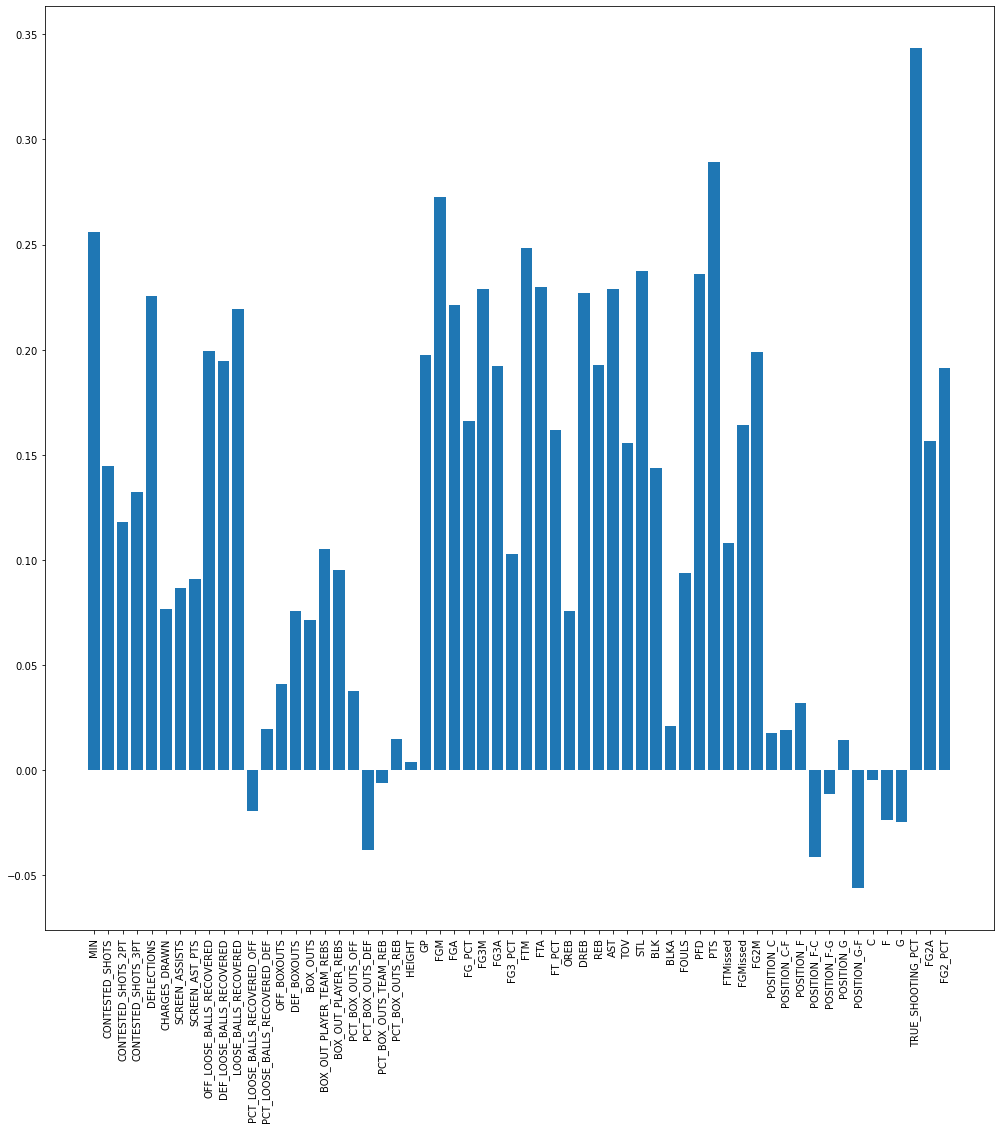

In [13]:
# All stats corr plot
make_corr_plot(all_stats.drop(['W','L','W_PCT','PLAYER_ID','DRAFT_YEAR'],axis=1),'PLUS_MINUS')

<BarContainer object of 59 artists>

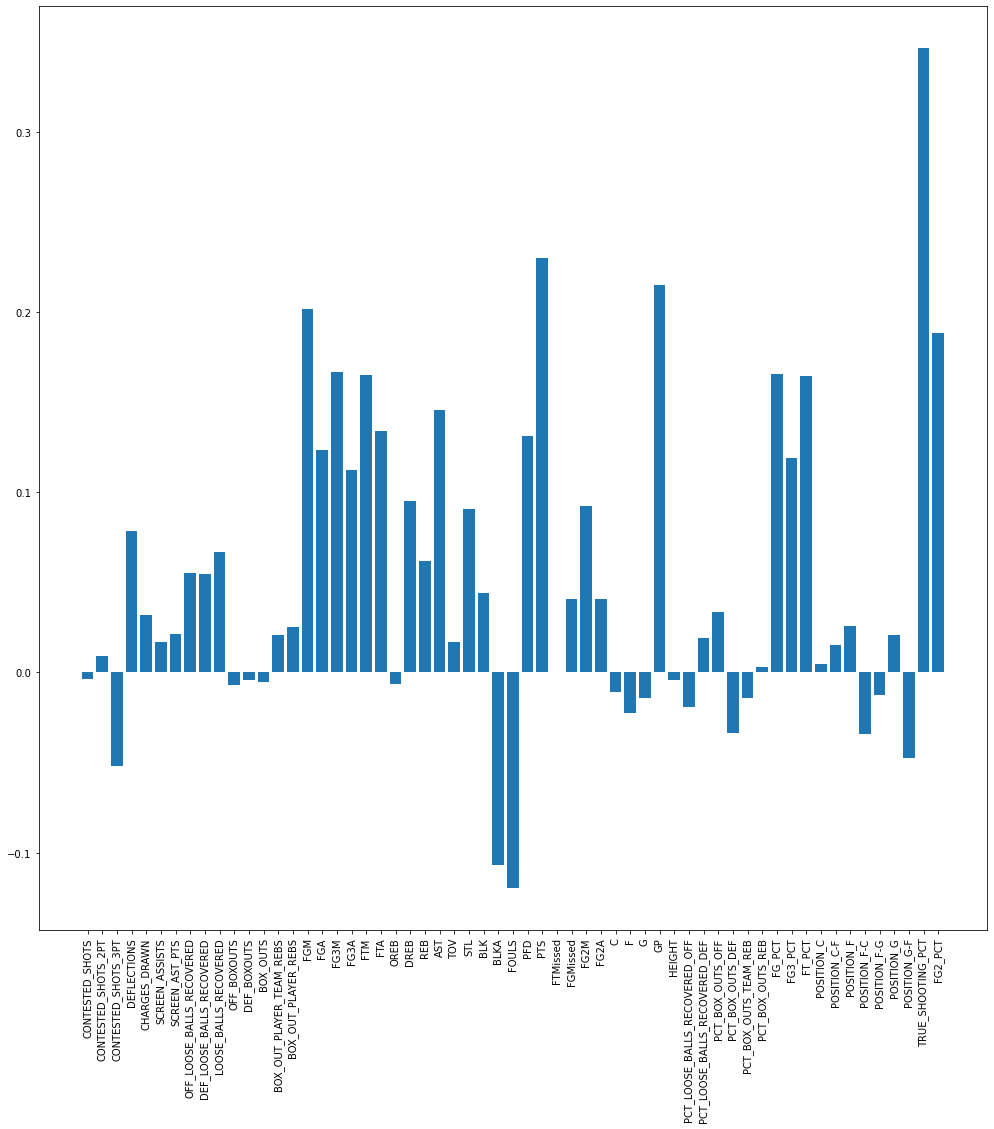

In [14]:
# Per min stats corr val
make_corr_plot(all_stats_with_per_min.drop(['W','L','W_PCT','PLAYER_ID','DRAFT_YEAR','MIN'],axis=1),'PLUS_MINUS')

<BarContainer object of 65 artists>

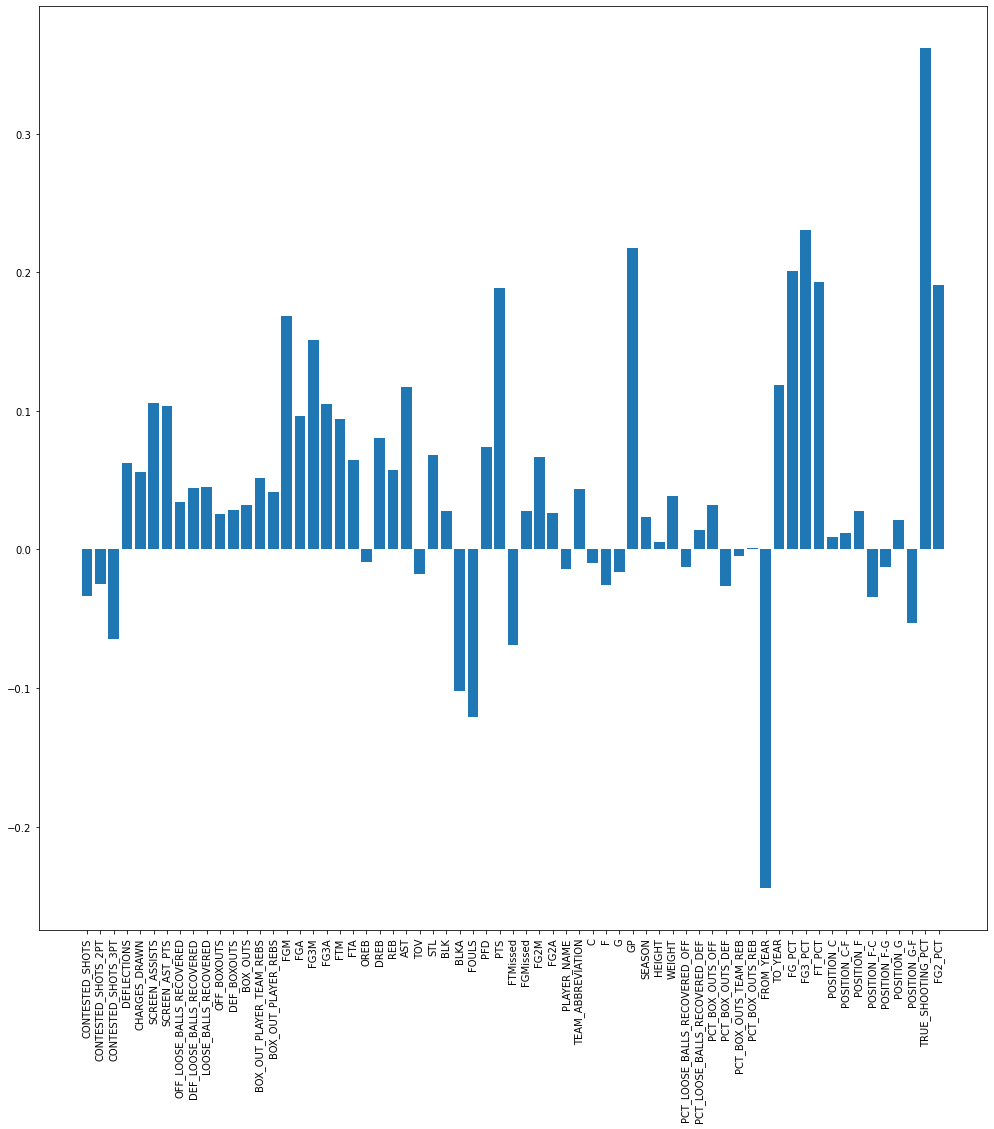

In [15]:
# Ranked per min stats corr val
make_corr_plot(all_stats_with_per_min.drop(['W','L','W_PCT','PLAYER_ID','DRAFT_YEAR','MIN'],axis=1).rank(method='min'),'PLUS_MINUS')

In [16]:
# Get stats for predicting (exclude draft year, win percent, etc.)
predict_plus_minus_stats = all_stats_with_per_min.drop(['W_PCT','PLAYER_ID','DRAFT_YEAR','GP','W','L','MIN',
                                          'W_PCT','SEASON','PLAYER_NAME','TEAM_ABBREVIATION',
                                         'FROM_YEAR','TO_YEAR'], axis=1)
# Rank the stats for predicting - I use rank as an inherent normalizing feature for the model
predict_plus_minus_stats_rank = predict_plus_minus_stats.rank(method='min')-1
predict_plus_minus_stats_rank = (predict_plus_minus_stats_rank-predict_plus_minus_stats_rank.min())/predict_plus_minus_stats_rank.max()
predict_plus_minus_stats_rank

,CONTESTED_SHOTS,CONTESTED_SHOTS_2PT,CONTESTED_SHOTS_3PT,DEFLECTIONS,CHARGES_DRAWN,SCREEN_ASSISTS,SCREEN_AST_PTS,OFF_LOOSE_BALLS_RECOVERED,DEF_LOOSE_BALLS_RECOVERED,LOOSE_BALLS_RECOVERED,OFF_BOXOUTS,DEF_BOXOUTS,BOX_OUTS,BOX_OUT_PLAYER_TEAM_REBS,BOX_OUT_PLAYER_REBS,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,FOULS,PFD,PTS,PLUS_MINUS,FTMissed,FGMissed,FG2M,FG2A,C,F,G,HEIGHT,WEIGHT,PCT_LOOSE_BALLS_RECOVERED_OFF,PCT_LOOSE_BALLS_RECOVERED_DEF,PCT_BOX_OUTS_OFF,PCT_BOX_OUTS_DEF,PCT_BOX_OUTS_TEAM_REB,PCT_BOX_OUTS_REB,FG_PCT,FG3_PCT,FT_PCT,POSITION_C,POSITION_C-F,POSITION_F,POSITION_F-C,POSITION_F-G,POSITION_G,POSITION_G-F,TRUE_SHOOTING_PCT,FG2_PCT
0,0.386301,0.639726,0.038356,0.261644,0.665753,0.656849,0.647945,0.699315,0.809589,0.803425,0.625342,0.748630,0.718493,0.648630,0.593151,0.757534,0.821918,0.667123,0.716438,0.701370,0.780137,0.686986,0.828767,0.772603,0.413014,0.569863,0.515753,0.721918,0.595890,0.119863,0.740411,0.765068,0.330822,0.878767,0.838356,0.661644,0.717123,0.0,1.0,0.0,0.625944,0.728395,0.350685,0.638356,0.472603,0.649153,0.258065,0.361644,0.351370,0.384510,0.194787,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.223973,0.360274
1,0.361644,0.586301,0.087671,0.176712,0.286301,0.646575,0.654110,0.845890,0.664384,0.782877,0.643151,0.695205,0.672603,0.596575,0.597945,0.634932,0.673288,0.474658,0.450000,0.596575,0.615753,0.719863,0.717123,0.719178,0.660959,0.693836,0.163014,0.656849,0.575342,0.234932,0.746575,0.630137,0.628082,0.688356,0.676712,0.625342,0.696575,0.0,1.0,0.0,0.625944,0.728395,0.645205,0.354110,0.560274,0.537288,0.279570,0.467808,0.481507,0.485949,0.302469,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.304795,0.329452
2,0.208904,0.400685,0.074658,0.078767,0.384932,0.657534,0.646575,0.734932,0.619178,0.687671,0.654110,0.357534,0.413014,0.362329,0.584247,0.547260,0.619863,0.341781,0.377397,0.630822,0.732192,0.730822,0.776027,0.763699,0.680137,0.456849,0.300685,0.600000,0.602055,0.176712,0.753425,0.542466,0.376712,0.883562,0.660959,0.621233,0.689041,0.0,1.0,0.0,0.625944,0.728395,0.589726,0.402740,0.847945,0.187288,0.709677,0.856164,0.378767,0.224126,0.150206,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.142466,0.327397
3,0.089726,0.282877,0.016438,0.158219,0.000000,0.580822,0.579452,0.650000,0.082877,0.266438,0.656164,0.031507,0.132877,0.182877,0.591781,0.545890,0.549315,0.418493,0.433562,0.573973,0.715068,0.743151,0.606164,0.676712,0.684247,0.767808,0.332877,0.741781,0.610274,0.233562,0.713699,0.557534,0.634932,0.904110,0.530137,0.579452,0.567808,0.0,1.0,0.0,0.625944,0.728395,0.964384,0.034932,0.997260,0.003390,0.795699,0.997945,0.582192,0.373544,0.115226,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.360274,0.552055
4,0.226712,0.442466,0.062329,0.054110,0.298630,0.620548,0.627397,0.480822,0.080137,0.187671,0.561644,0.127397,0.178767,0.219178,0.575342,0.679452,0.511644,0.354110,0.340411,0.617808,0.637671,0.739041,0.518493,0.606164,0.487671,0.606164,0.097945,0.620548,0.629452,0.202740,0.605479,0.628767,0.879452,0.727397,0.347260,0.704110,0.593151,0.0,1.0,0.0,0.625944,0.728395,0.929452,0.070548,0.907534,0.114407,0.791859,0.971233,0.835616,0.373544,0.339506,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.794521,0.889726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,0.360274,0.284247,0.685616,0.835616,0.000000,0.023288,0.021918,0.565068,0.516438,0.526027,0.000000,0.000000,0.000000,0.000685,0.000000,0.189726,0.294521,0.941781,0.928767,0.019863,0.021918,0.496575,0.142466,0.221233,0.282877,0.179452,0.810274,0.372603,0.000000,0.706849,0.033562,0.234247,0.272603,0.076712,0.399315,0.018493,0.020548,0.0,0.0,1.0,0.207275,0.387517,0.539726,0.456164,0.000000,1.000000,1.000000,0.000000,0.127397,0.738177,0.163923,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.550685,0.360274
1457,0.650000,0.665753,0.703425,0.685616,0.563014,0.676027,0.680137,0.372603,0.102740,0.149315,0.671233,0.456849,0.506164,0.634247,0.677

In [17]:
def train_test_split_df(df,Y_val,test_size=0.4,random_state=42):
    train_features, test_features = train_test_split(df.dropna(),test_size=test_size,random_state=random_state)
    train_labels = train_features.pop(Y_val)
#     train_labels['Y']=np.where(train_labels.values>0,1,0)
#     train_labels['asd']=np.where(train_labels[Y_val]>0,1,0)
    test_labels = test_features.pop(Y_val)
#     test_labels['asd']=np.where(test_labels[Y_val]>0,1,0)
    return np.asarray(train_features.sort_index()).astype(np.float32),\
        np.asarray(train_labels.sort_index()).astype(np.float32),\
        np.asarray(test_features.sort_index()).astype(np.float32),\
        np.asarray(test_labels.sort_index()).astype(np.float32)

In [18]:
# define a function to create the deep neural network model with feature normalization
def tf_model(norm):
    col_len = train_features.shape[1]
    model = tf.keras.Sequential([
    norm,
    tf.keras.layers.Dense((col_len), activation='relu', input_dim=col_len),
#     tf.keras.layers.Dense((col_len)*2, activation='relu'),
#     tf.keras.layers.Dense((col_len), activation='relu'),
#     tf.keras.layers.Dense(round((col_len)/2), activation='relu'),
#     tf.keras.layers.Dense(col_len, activation='relu'),
    tf.keras.layers.Dense(1)
                 ])
    model.compile(loss='mean_squared_error', optimizer='adam', #'rmsprop', 
                 metrics = ['mean_squared_error'] )
    return model

In [19]:
# ToDo
# Make a function for each major processing step
    # Make a combined function
# Try a deep learning model even though sparse points.
# If not enough, get multiple years of data
# Try using rank as a feature because it's inherently more normalized
# Use LinReg of rank features to gauge importance

In [20]:
# define a function to create the deep neural network model without feature normalization
def tf_model_no_norm():
    col_len = train_features.shape[1]
    model = tf.keras.Sequential([
#     norm,
    tf.keras.layers.Dense(col_len, activation='relu', input_dim=col_len),
#     tf.keras.layers.Dense(col_len*2, activation='relu'),
#     tf.keras.layers.Dense((col_len), activation='relu'),
#     tf.keras.layers.Dense(round(col_len/2), activation='relu'),
#     tf.keras.layers.Dense(col_len, activation='relu'),
    tf.keras.layers.Dense(1)
                 ])
    model.compile(loss='mean_squared_error', optimizer='adam', #'rmsprop', 
                 metrics = ['mean_squared_error'] )
    return model

In [21]:
all_models = {}
y_values = {}
x_values = {}
split_nums = [40,600,2432342,4645646,874,9846]
for i in split_nums:
    # Split the data
    train_features, train_labels, test_features, test_labels = train_test_split_df(predict_plus_minus_stats_rank,'PLUS_MINUS',random_state=i)
    tf_m = tf_model_no_norm()
    tf_m.fit(train_features, train_labels, epochs=50, verbose=False)
    # Run Dummy model
    dummy = DummyRegressor(strategy="mean")
    dummy.fit(train_features,train_labels)
    # Run Ridge model
    ridge = Ridge(alpha=1.0)
    ridge.fit(train_features,train_labels)
    # Run Linear model
    lin = LinearRegression()
    lin.fit(train_features,train_labels)
    # Run Decision Tree model
    dtr = tree.DecisionTreeRegressor(max_depth=10)
    dtr.fit(train_features,train_labels)
    # Store the models
    all_models[str(i)+'tf_m'] = tf_m
    all_models[str(i)+'dummy'] = dummy
    all_models[str(i)+'ridge'] = ridge
    all_models[str(i)+'dtr'] = dtr
    all_models[str(i)+'lin'] = lin
    y_values[i] = test_labels
    x_values[i] = test_features
    print(i)

40
600
2432342
4645646
874
9846


In [22]:
results_dict = {'split':[]}
# # Can store results of the deep learning model if I want
# df_results = pd.DataFrame([[None,None]],columns=['Actual','Pred'])
for i in split_nums:
    # Store each split value
    results_dict['split'].append(i)
    for j in ['tf_m','dummy','ridge','dtr','lin']:
        # Predict for each model and score R2 of pred vs actual
        preds = all_models[str(i)+j].predict(x_values[i]).flatten()
        r2 = r2_score(y_values[i],preds)
        mse = round(1000*mean_squared_error(y_values[i],preds),1)
        # Store results in a dictionary to reference later if desired
        if j+'r2' in results_dict:
            results_dict[j+'r2'].append(r2)
            results_dict[j+'mse'].append(mse)
        else:
            results_dict[j+'r2']=[r2]
            results_dict[j+'mse']=[mse]
# #         Uncomment to Plot scatter plots of Pred vs Actual in a loop
#         plt.figure(figsize=(12,12))
#         plt.scatter(y_values[i],preds)
#         title = str(i)+j+', R2 = '+str(round(r2,4))+', MSE = '+str(mse)
#         plt.suptitle(title)
#         plt.xlabel('Actual')
#         plt.ylabel('Predicted')
#         plt.show()
# #       Can store results of the deep learning model if I want
#         if j == 'tf_m':
#             df_results=df_results.append(pd.DataFrame.from_dict({'Actual':y_values[i],'Pred':preds}))
# Make a dataframe from the results dictionary
results = pd.DataFrame(results_dict)
results

,split,tf_mr2,tf_mmse,dummyr2,dummymse,ridger2,ridgemse,dtrr2,dtrmse,linr2,linmse
0,40,0.062932,74.6,-9.494358e-04,79.7,0.187884,64.7,-0.478493,117.7,0.166392,66.4
1,600,0.186920,67.4,-1.864856e-04,82.9,0.244644,62.6,-0.319306,109.3,0.224728,64.2
2,2432342,0.160640,68.7,-3.655182e-04,81.9,0.245367,61.8,-0.360851,111.4,0.233550,62.7
3,4645646,0.187100,71.3,-6.278039e-08,87.7,0.264620,64.5,-0.269396,111.3,0.257201,65.2
4,874,0.162190,69.1,-2.166380e-02,84.2,0.234461,63.1,-0.303719,107.5,0.210735,65.1
5,9846,0.093553,74.0,-1.608246e-03,81.7,0.228183,63.0,-0.510840,123.3,0.193444,65.8


In [23]:
# # Plotting feature importance from linear regression, but no need anymore after adding a corr plot function above
# lin = LinearRegression()
# importance = []
# z = 0
# # lin.fit(player_general_per_min_rank_norm.drop('PLUS_MINUS',axis=1),player_general_per_min_rank_norm['PLUS_MINUS'])
# for i in predict_plus_minus_stats_rank.drop('PLUS_MINUS',axis=1).columns:
#     lin.fit(predict_plus_minus_stats_rank[i].values.reshape(-1,1),predict_plus_minus_stats_rank['PLUS_MINUS'])
#     importance.append(lin.coef_[0])
#     z+=1
# plt.figure(figsize=(17,17))
# plt.xticks(rotation=90)
# plt.bar(predict_plus_minus_stats_rank.drop('PLUS_MINUS',axis=1).columns,importance)

In [24]:
# # Saving time for salary with code from here: https://medium.com/swlh/linking-nba-salary-to-performance-sample-player-analysis-with-python-2c568455b306
# r = requests.get('https://hoopshype.com/salaries/')
# r_html = r.text

# soup = BeautifulSoup(r_html, 'html.parser')

# salary_table = soup.find('table')
# length=len(salary_table.find_all("td"))

# player_names=[salary_table.find_all("td")[i].text.strip() for i in range(9,length,8)]

# column1=[salary_table.find_all("td")[i].text.strip() for i in range(10,length,8)]
# column2=[salary_table.find_all("td")[i].text.strip() for i in range(11,length,8)]
# column3=[salary_table.find_all("td")[i].text.strip() for i in range(12,length,8)]
# column4=[salary_table.find_all("td")[i].text.strip() for i in range(13,length,8)]
# column5=[salary_table.find_all("td")[i].text.strip() for i in range(14,length,8)]
# column6=[salary_table.find_all("td")[i].text.strip() for i in range(15,length,8)]
# df_dict={'player_names':player_names,
#         '2019/20':column1,
#         '2020/21':column2,
#         '2021/22':column3,
#         '2022/23':column4,
#         '2023/24':column5,
#         '2024/25':column6}
        
# salary_df = pd.DataFrame(df_dict)
# salary_df